# Homework 7 - Let's have another look at the Titanic

The objective of this homework is to practice k-means clustering. To successfully complete this homework, you may use any resources available to you. 

Last week, we used supervised classification to understand what drives survivability. This week we explore whether the machine can figure it out on it's own.

Get the `titanic3.csv` data (Source: [Link](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3info.txt)).

1. Analyze the data using pandas.
    * Create a column `child` that specifies whether the person is a child (age <= 10).
    * Create a column `family_size` that specifies the size of the family of that person (Please note that there are two relevant columns for this step.
2. Develop clusters for the dataset.
    * Impute the `age` column with the **median** (Please note that this a very simplified step. Imputing is usually way more complex).
    * Drop all remaining NaN values.
    * Preprocess the `sex` column using LabelEncoder.
    * Preprocess the `child` column using LabelEncoder (not actually necessary but for systematic purposes).
    * Scale the data set to standardize the dataset using `sklearn.preprocessing.scale`
    * Run a KMeans cluster analysis. Pick an appropriate number of clusters.
    * Interpret the results.
3. Implement a search for the best number of clusters using the silhouette score from `sklearn.metrics`.
    * Set the parameters to 2,3,4,5,6 clusters.
    * Interpret the best results.
    * Try to find names for the clusters.
    
Hints:
* Explain what you are doing.
* Use references.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [87]:
import sklearn as sk
import sklearn.tree as tree
import sklearn.preprocessing as pp
import sklearn.metrics as sm
import matplotlib.pyplot as plt

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
%matplotlib inline

In [51]:
raw = pd.read_csv("https://raw.githubusercontent.com/mschermann/msis2802winter2018homework/master/\
titanic3.csv")

In [52]:
tc = raw.copy()

## Description of the dataset

Each row is a passenger on the Titanic. The columns report attributes for the passengers:

| Column | Description | Relevant for this homework|
|--------|-------------|--------|
|`survived`|1 = survived, 0 = died | **X**|
|`pclass`| 1 = first class, 2 = second class, 3 = third class |**X**|
|`name`| Name of the passenger| |
|`sex`| male or female|**X**|
|`age`| age in years|**X**|
|`sibsp`| The number of siblings or spouses that are also traveling on the Titanic| **X**|
|`parch`| The number of parents or childen that are also traveling on the Titanic| **X**|
|`ticket`|The ticket number| |
|`fare`| The ticket price | |
|`cabin`| The cabin number | |
|`embarked`| The starting city | |
|`boat`| The emergency boat number | |
|`body`| The identification number of the body | |
|`home.dest`| The destination of the passenger | |

Cleaning Data

In [53]:
tc['age'].fillna((tc['age'].median()), inplace=True)
tc.tail()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1305,3.0,0.0,"Zabour, Miss. Thamine",female,28.0,1.0,0.0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3.0,0.0,"Zakarian, Mr. Mapriededer",male,26.5,0.0,0.0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3.0,0.0,"Zakarian, Mr. Ortin",male,27.0,0.0,0.0,2670,7.2250,NaN,C,NaN,NaN,NaN
1308,3.0,0.0,"Zimmerman, Mr. Leo",male,29.0,0.0,0.0,315082,7.8750,NaN,S,NaN,NaN,NaN
1309,NaN,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
tc = tc.drop(tc.index[1309])

In [55]:
tc.tail()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1304,3.0,0.0,"Zabour, Miss. Hileni",female,14.5,1.0,0.0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3.0,0.0,"Zabour, Miss. Thamine",female,28.0,1.0,0.0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3.0,0.0,"Zakarian, Mr. Mapriededer",male,26.5,0.0,0.0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3.0,0.0,"Zakarian, Mr. Ortin",male,27.0,0.0,0.0,2670,7.2250,NaN,C,NaN,NaN,NaN
1308,3.0,0.0,"Zimmerman, Mr. Leo",male,29.0,0.0,0.0,315082,7.8750,NaN,S,NaN,NaN,NaN


In [56]:
tc['child'] = np.where(tc['age']<=10, '1.0', '0.0')
tc.tail()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,child
1304,3.0,0.0,"Zabour, Miss. Hileni",female,14.5,1.0,0.0,2665,14.4542,NaN,C,NaN,328.0,NaN,0.0
1305,3.0,0.0,"Zabour, Miss. Thamine",female,28.0,1.0,0.0,2665,14.4542,NaN,C,NaN,NaN,NaN,0.0
1306,3.0,0.0,"Zakarian, Mr. Mapriededer",male,26.5,0.0,0.0,2656,7.2250,NaN,C,NaN,304.0,NaN,0.0
1307,3.0,0.0,"Zakarian, Mr. Ortin",male,27.0,0.0,0.0,2670,7.2250,NaN,C,NaN,NaN,NaN,0.0
1308,3.0,0.0,"Zimmerman, Mr. Leo",male,29.0,0.0,0.0,315082,7.8750,NaN,S,NaN,NaN,NaN,0.0


Determining the family size as addition of 2 columns(sibsp and parch) and adding a one to it.

In [57]:
tc['family_size'] = tc['parch']+tc['sibsp']+1
tc.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,child,family_size
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",0.0,1.0
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1.0,4.0
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",1.0,4.0
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",0.0,4.0
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",0.0,4.0


Dropping columns as they have NaN values and they are enot relevant to our analysis

In [71]:
tc.drop(['name','ticket','fare','cabin','embarked','boat','body','home.dest'],axis = 1,inplace = True)

In [72]:
tc.head()

,pclass,survived,sex,age,sibsp,parch,child,family_size
0,1.0,1.0,female,29.0000,0.0,0.0,0.0,1.0
1,1.0,1.0,male,0.9167,1.0,2.0,1.0,4.0
2,1.0,0.0,female,2.0000,1.0,2.0,1.0,4.0
3,1.0,0.0,male,30.0000,1.0,2.0,0.0,4.0
4,1.0,0.0,female,25.0000,1.0,2.0,0.0,4.0


Preprocessing the sex and child columns

In [74]:
le_sex = pp.LabelEncoder()
y = le_sex.fit_transform(tc['sex'].astype(str))
y

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [75]:
le_child = pp.LabelEncoder()
y1 = le_child.fit_transform(tc['child'].astype(str))
y1

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [76]:
X = tc.drop(['sex'],axis = 1)

Scaling the data set to standardize based on mean

In [78]:
scaled_data = sk.preprocessing.scale(X,with_mean=True)

In [79]:
scaled_data

array([[-1.54609786,  1.27200629, -0.03900549, ..., -0.4449995 ,
        -0.26517709, -0.55834605],
       [-1.54609786,  1.27200629, -2.21595217, ...,  1.86652569,
         3.77106487,  1.33674898],
       [-1.54609786, -0.78615963, -2.13197749, ...,  1.86652569,
         3.77106487,  1.33674898],
       ..., 
       [ 0.84191642, -0.78615963, -0.23279919, ..., -0.4449995 ,
        -0.26517709, -0.55834605],
       [ 0.84191642, -0.78615963, -0.19404045, ..., -0.4449995 ,
        -0.26517709, -0.55834605],
       [ 0.84191642, -0.78615963, -0.03900549, ..., -0.4449995 ,
        -0.26517709, -0.55834605]])

To determine the number of clusters

In [81]:
np.unique(y)
tc['sex'].unique()

array([0, 1], dtype=int64)

array(['female', 'male'], dtype=object)

There are 2 clusters.(male & female)

In [83]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
y_kmeans = kmeans.fit_predict(scaled_data)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

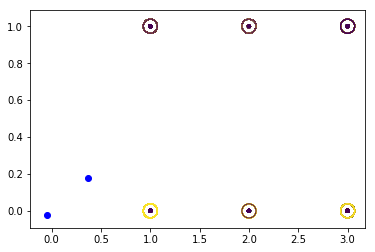

In [91]:
orig = plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y, s=200)
orig.set_facecolor('None') # Set color to None
plt.scatter(X.iloc[:,0], X.iloc[:,1], s=10, c=y_kmeans)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], c='blue' );

In [106]:
from sklearn.manifold import Isomap

In [108]:
iso = Isomap(n_components=2)
tc_reduced = iso.fit_transform(tc.drop('sex', axis=1))

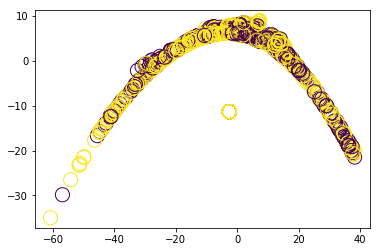

In [109]:
orig_reduced = plt.scatter(tc_reduced[:,0],tc_reduced[:, 1], c=y, s=200)
orig_reduced.set_facecolor('None') 

In [94]:
from sklearn.pipeline import Pipeline

In [96]:
X_complete = tc.drop(['sex'], axis=1)

In [97]:
pipe = Pipeline([('scale', pp.StandardScaler()),('cluster', KMeans())])

In [98]:
pipe = Pipeline([('cluster', KMeans())])

In [99]:
cluster__n_clusters = [2,3,4,5,6] 

In [100]:
from sklearn.metrics import silhouette_score

In [103]:
score = pd.DataFrame(columns=['clusters', 'silhouette_score', 'labels'])
for n_cluster in cluster__n_clusters:
    pipe = pipe.set_params(cluster__n_clusters = n_cluster)
    #pipe = pipe_no_iso.set_params(cluster__n_clusters =n_cluster)
    #pipe = KMeans(n_clusters=n_cluster)
    labels = pipe.fit_predict(X_complete)
    silhouette_avg = silhouette_score(X, labels)
    score = score.append({'clusters':n_cluster, 'silhouette_score': silhouette_avg, 'labels': labels}, ignore_index=True)

In [104]:
score.sort_values(by='silhouette_score') 

,clusters,silhouette_score,labels
3,5,0.517031,"[0, 3, 3, 0, 0, 4, 1, 4, 1, 1, 4, 2, 2, 0, 1, ..."
2,4,0.521002,"[0, 2, 2, 0, 0, 1, 1, 3, 1, 1, 3, 0, 0, 0, 1, ..."
4,6,0.523141,"[1, 4, 4, 1, 1, 2, 5, 0, 2, 5, 2, 3, 1, 1, 5, ..."
1,3,0.545424,"[0, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, ..."
0,2,0.587556,"[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, ..."


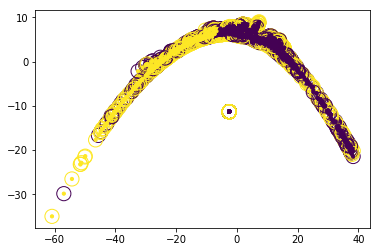

In [113]:
orig_reduced = plt.scatter(tc_reduced[:,0], tc_reduced[:, 1], c=y, s=200)
orig_reduced.set_facecolor('None') # Set color to None
plt.scatter(tc_reduced[:,0],tc_reduced[:,1], s=10, c=score.iloc[0,2]);

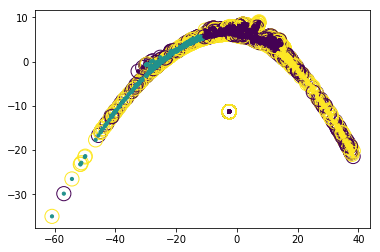

In [116]:
orig_reduced = plt.scatter(tc_reduced[:,0], tc_reduced[:, 1], c=y, s=200)
orig_reduced.set_facecolor('None') # Set color to None
plt.scatter(tc_reduced[:,0],tc_reduced[:,1], s=10, c=score.iloc[1,2]);

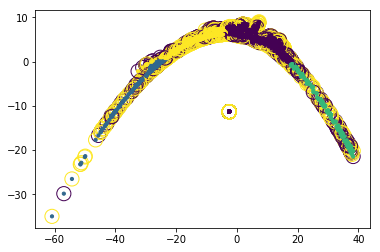

In [118]:
orig_reduced = plt.scatter(tc_reduced[:,0], tc_reduced[:, 1], c=y, s=200)
orig_reduced.set_facecolor('None') # Set color to None
plt.scatter(tc_reduced[:,0],tc_reduced[:,1], s=10, c=score.iloc[2,2]);

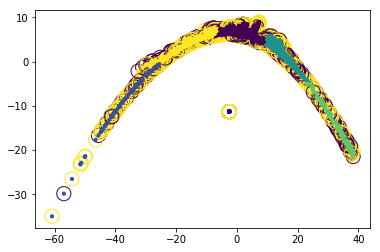

In [119]:
orig_reduced = plt.scatter(tc_reduced[:,0], tc_reduced[:, 1], c=y, s=200)
orig_reduced.set_facecolor('None') # Set color to None
plt.scatter(tc_reduced[:,0],tc_reduced[:,1], s=10, c=score.iloc[3,2]);

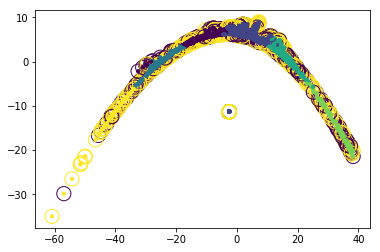

In [120]:
orig_reduced = plt.scatter(tc_reduced[:,0], tc_reduced[:, 1], c=y, s=200)
orig_reduced.set_facecolor('None') # Set color to None
plt.scatter(tc_reduced[:,0],tc_reduced[:,1], s=10, c=score.iloc[4,2]);

Based on the silhoutte score,cluster 5 has the best clustering out of all as the two colours are kind of clearly visible.
Silhoutte score will give the accuracy with consisitency of data